In [43]:
# Data Handling
import numpy as np
import pandas as pd

# Vizz
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reading Data

In [44]:
data_path = '../data/' # ./data or ../data

In [45]:
part_1 = pd.read_csv(data_path+'data_part_1.csv', index_col=False); part_1 = part_1[part_1.columns[1:]] # Getting rid of idx col
part_2 = pd.read_csv(data_path+'data_part_2.csv', index_col=False); part_2 = part_2[part_2.columns[1:]] # Getting rid of idx col

# Joining datasets

In [46]:
data_df=pd.concat([part_1, part_2], axis=0,join="inner")

# Having a dataset for each trait (X1,...,X20):

# Create a dataset without missing values for each trait + List of those data

In [47]:
# We have 20 target variables and so, we split the data into 20 different dataframes for each target variable. 
# After that, we drop the rows with missing values in the target variable and then, we drop the target variable from the dataframes.
# We are left with 20 dataframes with no missing values in the target variable.
# Now, we create a list of target variables and a list of input variables.
input_cols = data_df.columns[20:]
target_cols = data_df.columns[:20]
y=[]
x=[]
for i in range(20):
    y.append(data_df.iloc[:,i].dropna(axis=0))
    x_temp=data_df.iloc[y[i].index,20:]
    x.append(x_temp)

## Train, Validation, and Test split of the list of the data

In [48]:
# We now split the list of input variables and target variables into train, test and validation sets.
# So, we will have a list of 20 train sets, 20 test sets and 20 validation sets.
train_xl = []
train_yl = []
test_xl = []
test_yl = []
val_xl = []
val_yl = []
for X_matrix, y_target in zip(x, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X_matrix, y_target, test_size=0.3, random_state=42,shuffle=True)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    train_xl.append((X_train))
    train_yl.append((y_train))
    test_xl.append((X_test))
    test_yl.append((y_test))
    val_xl.append((X_validation))
    val_yl.append((y_validation))

## Normalization of the train, validation, and test data list

In [49]:
X_train_scaled=[]
X_test_scaled=[]
X_val_scaled=[]
robust_z_train=[]
robust_z_val=[]
robust_z_test=[]

for i in range(20):
# Z-score (STD) normalization
    scaler = StandardScaler()
    X_train_scaled_temp = scaler.fit_transform(train_xl[i])
    X_test_scaled_temp = scaler.transform(test_xl[i])
    X_val_scaled_temp = scaler.transform(val_xl[i])
    X_train_scaled.append(X_train_scaled_temp)
    X_test_scaled.append(X_test_scaled_temp)
    X_val_scaled.append(X_val_scaled_temp)
    

# Z-score (Robust) normalization
    train_medians = np.median(train_xl[i], axis=0)
    train_mads = np.median(np.abs(train_xl[i] - train_medians), axis=0)
    robust_z_train_temp = (train_xl[i] - train_medians) / (1.4826 * train_mads)
    robust_z_val_temp = (val_xl[i] - train_medians) / (1.4826 * train_mads)
    robust_z_test_temp = (test_xl[i] - train_medians) / (1.4826 * train_mads)
    robust_z_train.append(robust_z_train_temp)
    robust_z_val.append(robust_z_val_temp)
    robust_z_test.append(robust_z_test_temp)


## PCA for the list of train matrices

In [50]:
pca_variances = []
pc_list = []
pc_scores = []
for i in range(20):
    pca = PCA()
    pca.fit(X_train_scaled[i])
    pca_variances.append(pca.explained_variance_ratio_)
    pc_list.append(pca.components_)
    pc_scores.append(pca.score)


## Individual and Cumulative Variance for different traits

C:\Users\98915\AppData\Local\Temp\ipykernel_10144\3151216524.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


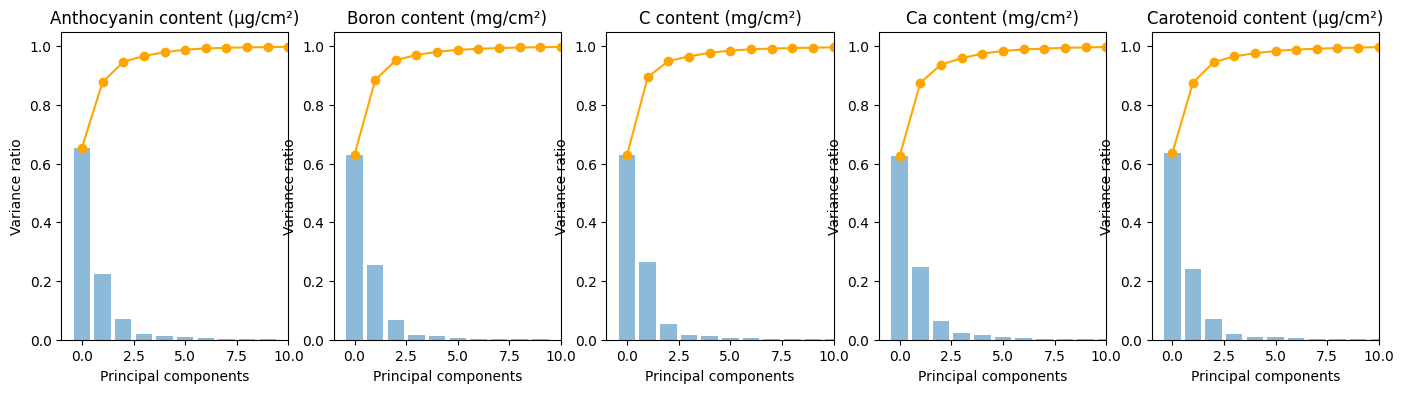

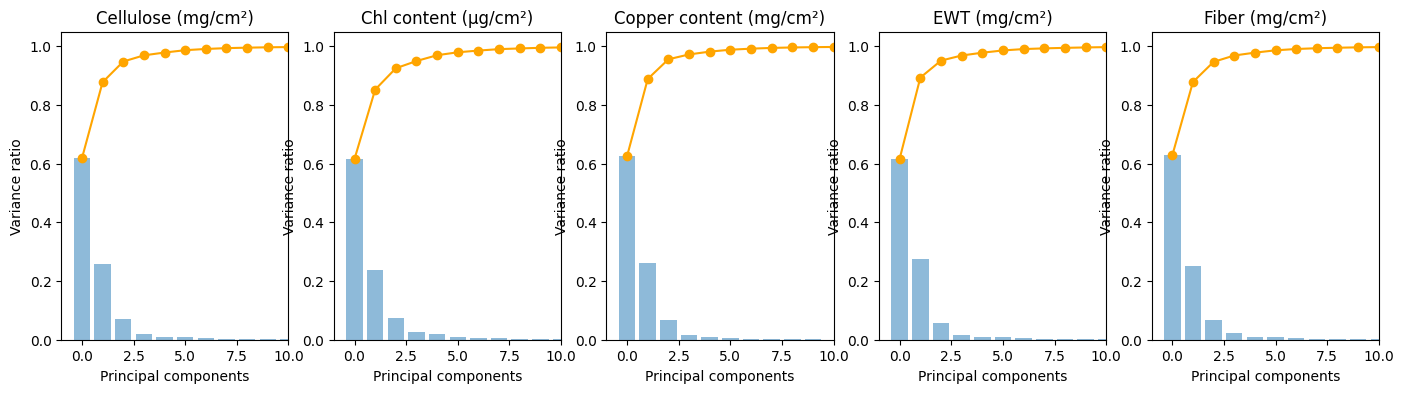

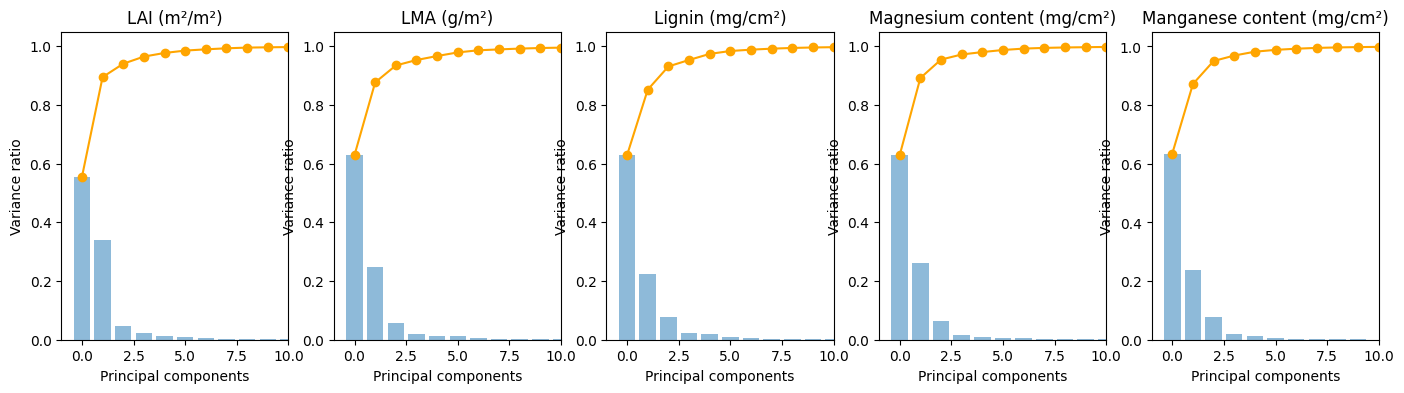

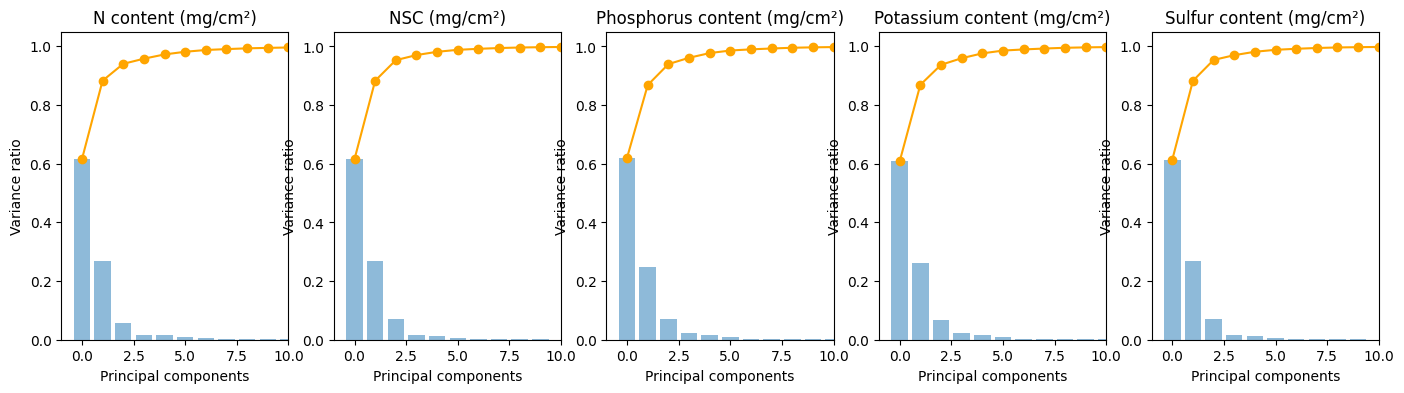

In [51]:
for i in range(4):
  fig,axs=plt.subplots(1,5,figsize=(17,4))  
  for j in range(5):
    if j+i*5>19:
      break
    axs[j].bar(range(len(pca_variances[j+i*5])), pca_variances[j+i*5], alpha=0.5, align='center', label='individual variance')
    axs[j].plot(np.arange(len(pca_variances[j+i*5])), np.cumsum(pca_variances[j+i*5]), '-o', c='orange', label='Accumulated Variance')
    axs[j].set_xlabel('Principal components') 
    axs[j].set_ylabel('Variance ratio')
    axs[j].set_title(target_cols[j+i*5])
    axs[j].set_xlim(-1, 10)  
  fig.show()
  

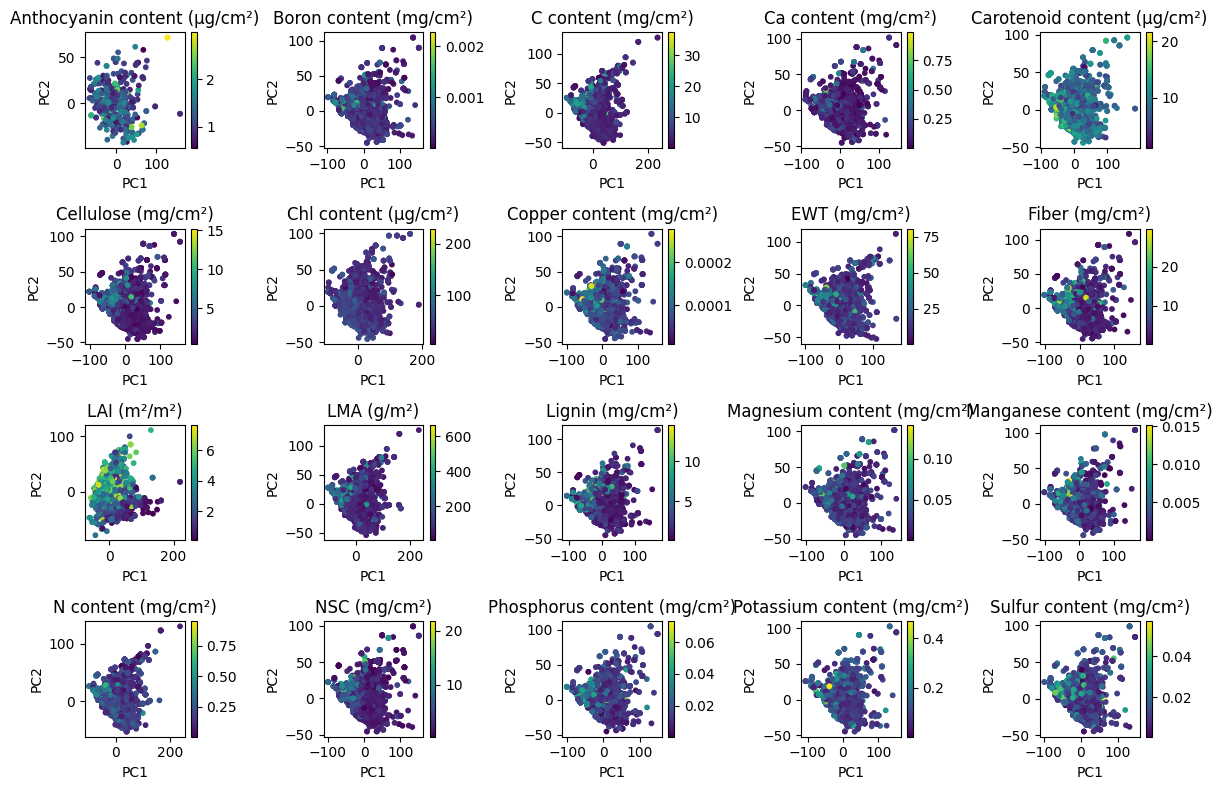

In [52]:
pca=PCA(n_components=2)

x_pca=[pca.fit_transform(df) for df in X_train_scaled]

# Visualize PCA results
plt.figure(figsize=(12,8))
for i in range(len(x_pca)):
    plt.subplot(4, 5, i + 1)
    plt.scatter(x_pca[i][:, 0], x_pca[i][:, 1], c=train_yl[i], cmap='viridis', s=10)
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(target_cols[i])
plt.tight_layout()
plt.show()


# Missing value anlalysis

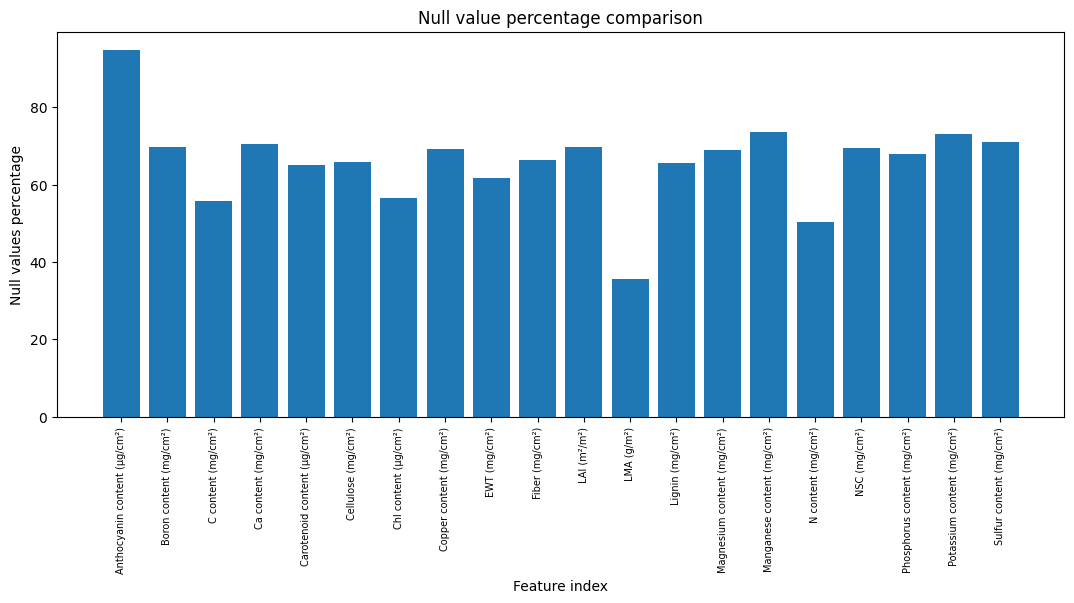

In [53]:
missing_data = data_df.isna().sum()[0:20]/len(data_df)*100
plt.subplots(figsize = (13, 5))
plt.bar(np.arange(len(missing_data)), missing_data)
plt.xticks(np.arange(len(missing_data)), missing_data.index, rotation=90, fontsize = 7)
plt.ylabel("Null values percentage")
plt.xlabel("Feature index")
plt.title("Null value percentage comparison")
plt.show()

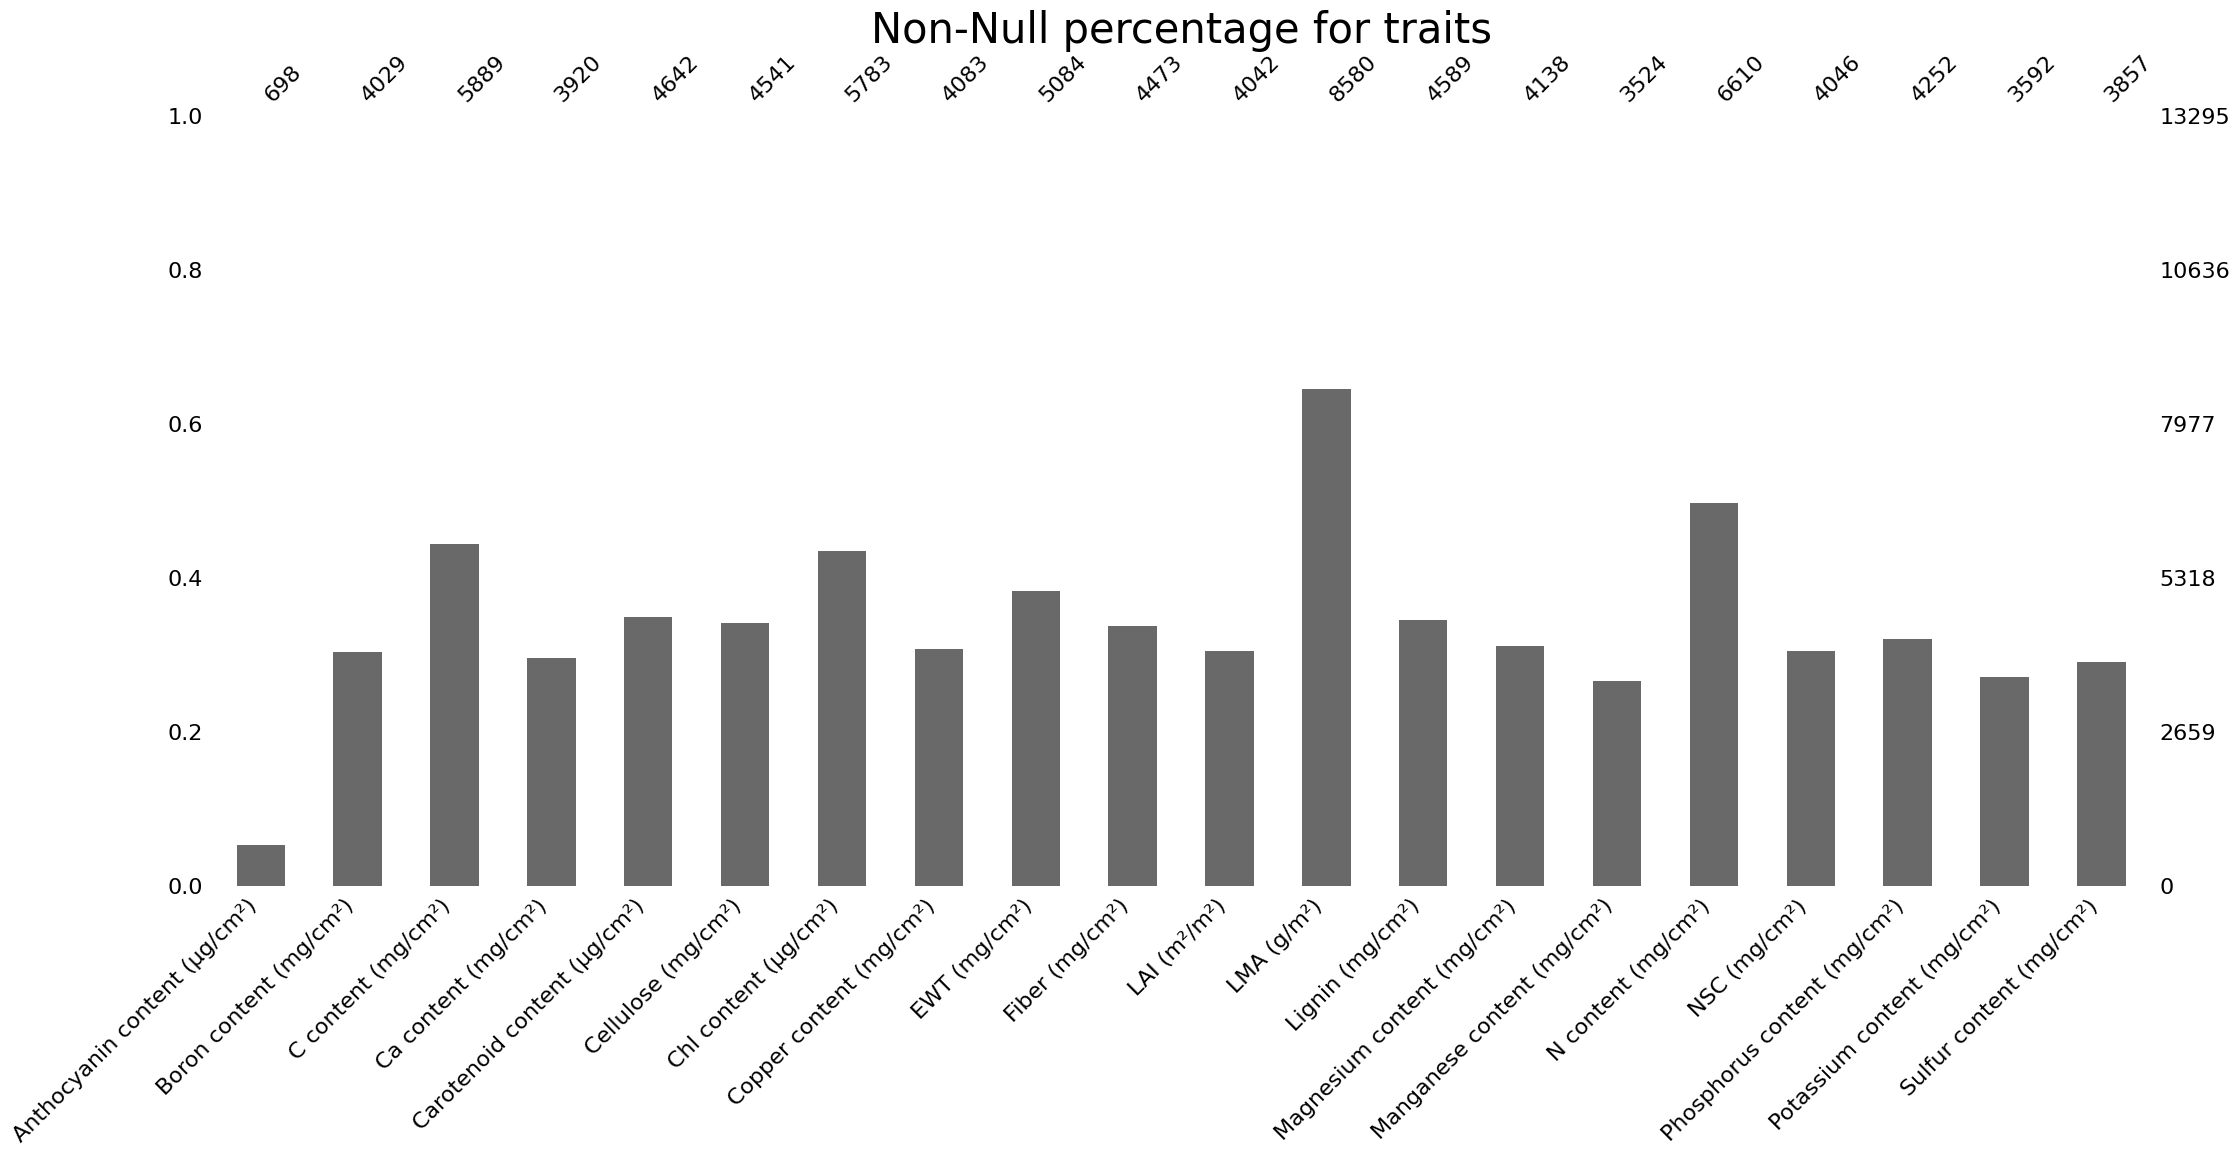

In [54]:
msno.bar( data_df[missing_data.index])
plt.title("Non-Null percentage for traits", size=30)
plt.show()

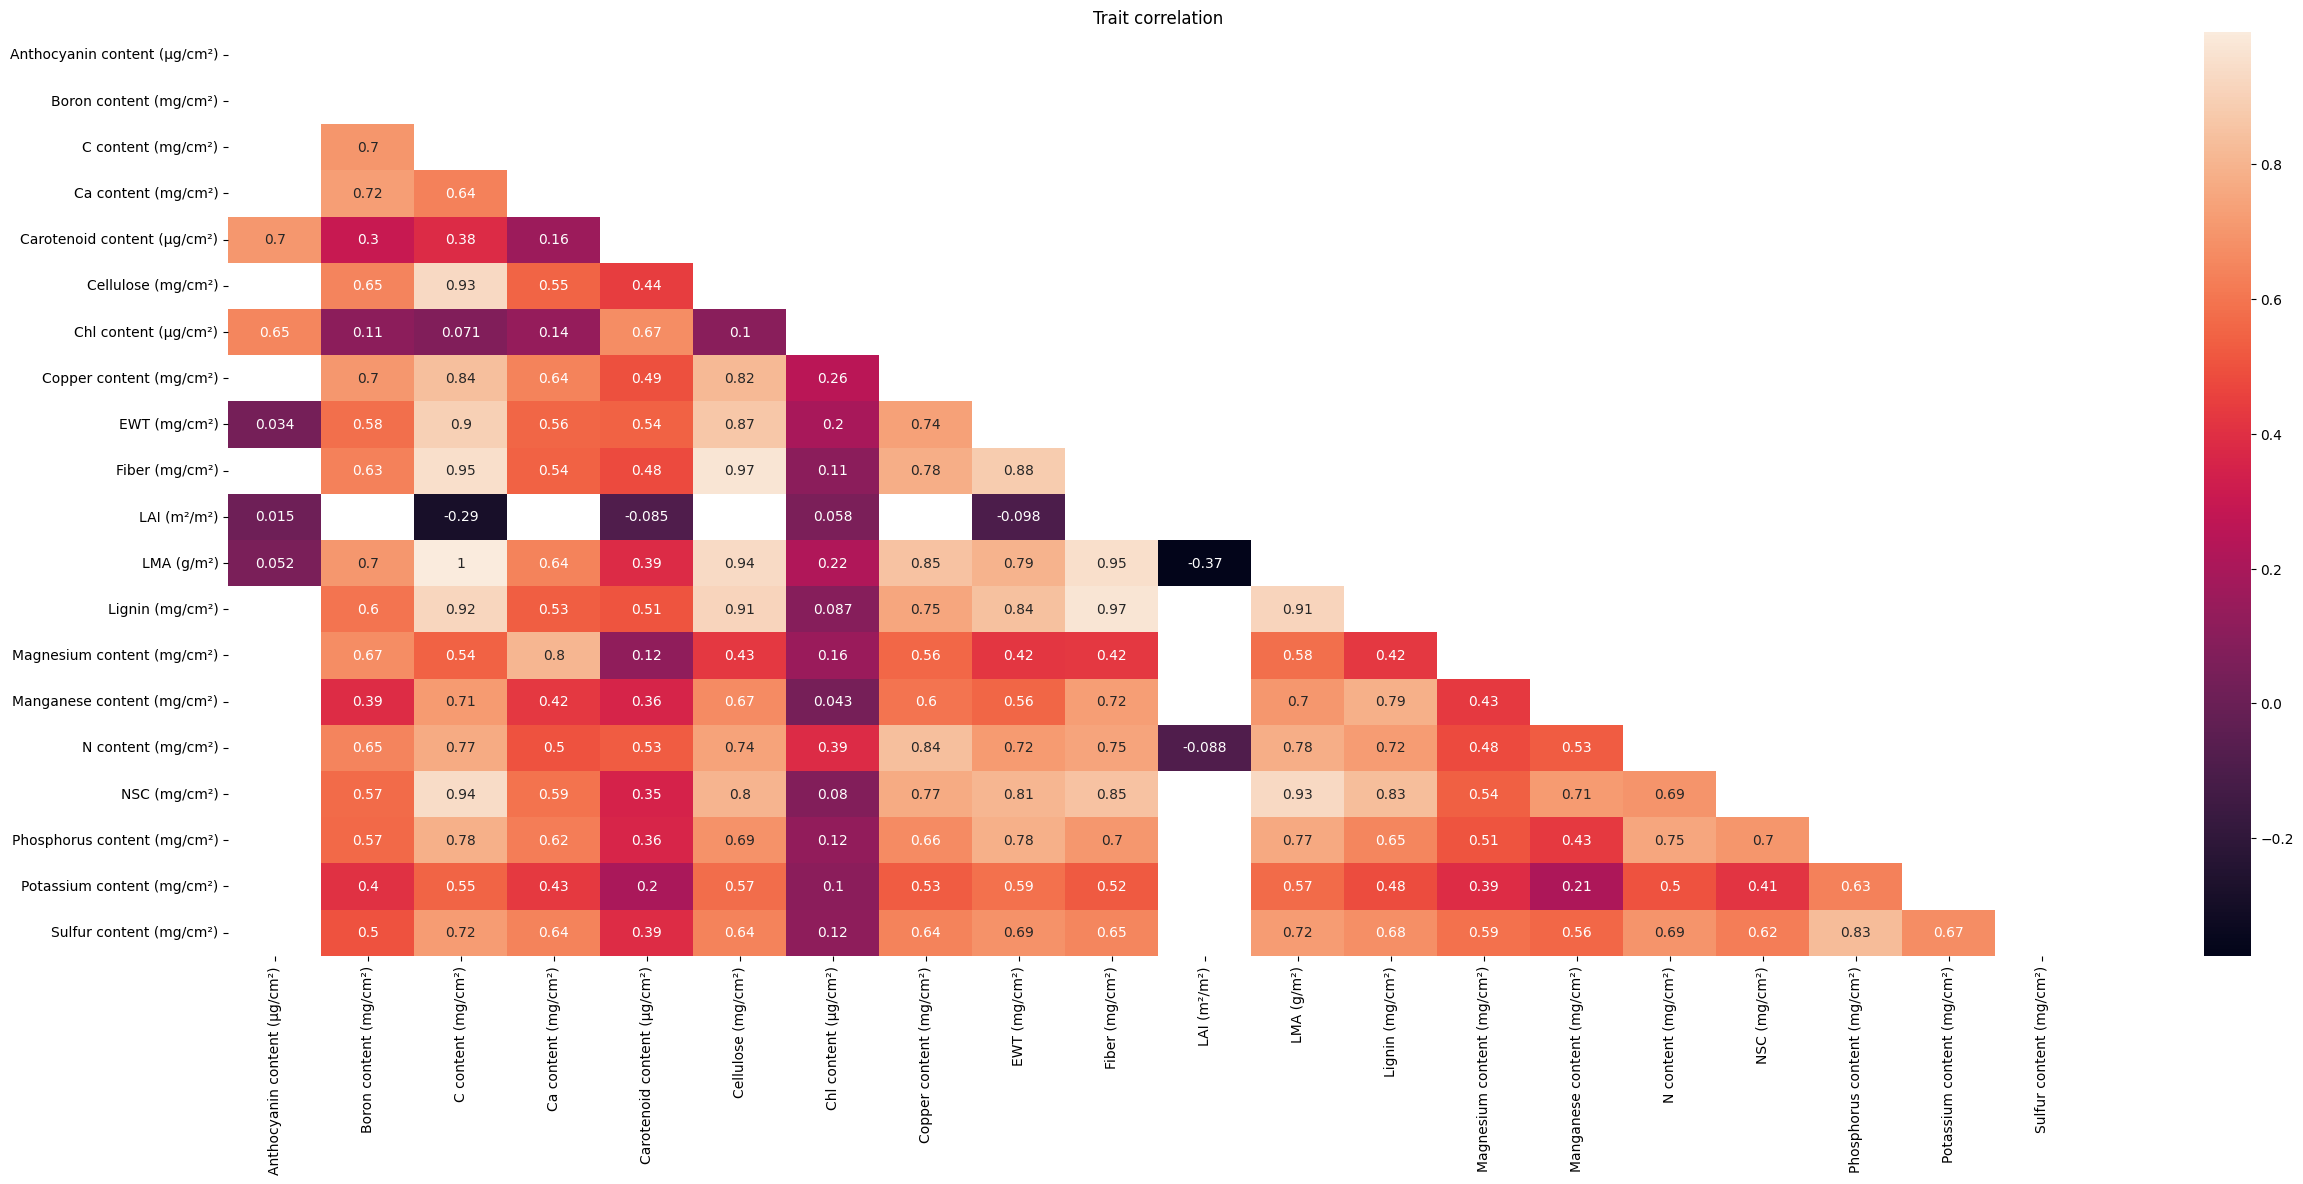

In [55]:
plt.subplots(figsize=(30, 12))
corr = data_df[missing_data.index].corr()
sns.heatmap( corr, annot=True, mask = np.triu(corr))
plt.title("Trait correlation")
plt.show()

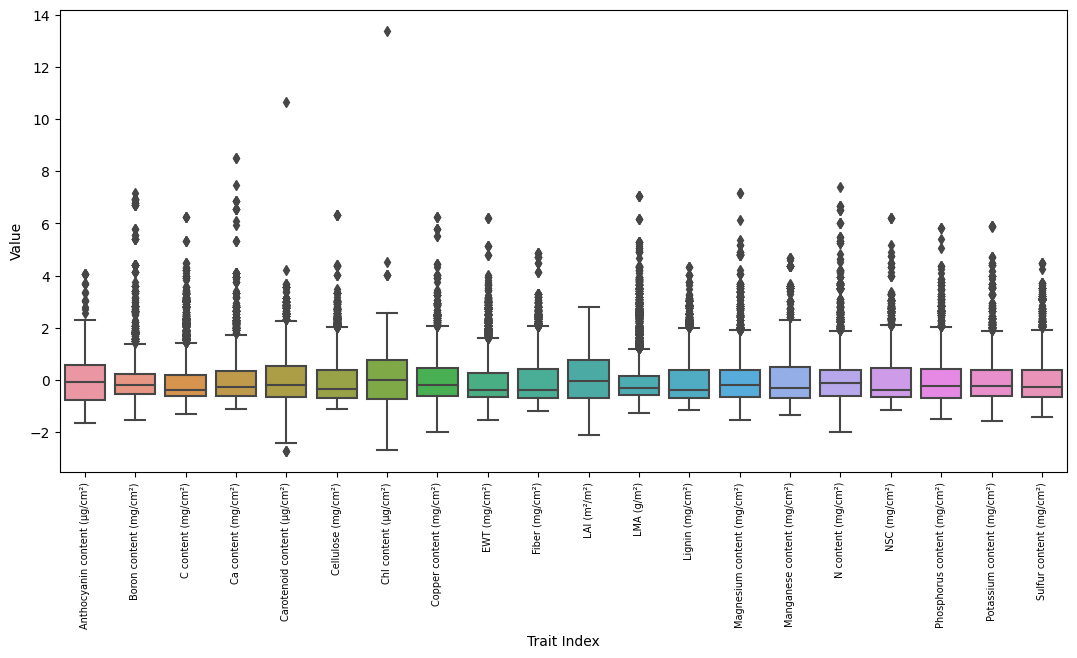

In [56]:
data_df_zscore = (data_df-data_df.mean())/data_df.std()
plt.figure(figsize=(13,6))
sns.boxplot(data=data_df_zscore.iloc[:,0:20])
plt.xticks(np.arange(len(missing_data)), missing_data.index,rotation=90, fontsize = 7)
plt.xlabel('Trait Index')
plt.ylabel('Value')
plt.show()

# Whole data analysis:

# Train Validation Test split

In [57]:
data_shape = data_df.shape[0]
shuffled_data = np.arange(data_shape)
np.random.shuffle( shuffled_data )


train_partition = data_df.iloc[shuffled_data[:int(0.70*data_shape)]]
val_partition = data_df.iloc[shuffled_data[int(0.70*data_shape):int(0.85*data_shape)]]
test_partition = data_df.iloc[shuffled_data[int(0.85*data_shape):]]

In [58]:
X_train, y_train = train_partition[input_cols], train_partition[target_cols]
X_val, y_val = val_partition[input_cols], val_partition[target_cols]
X_test, y_test = test_partition[input_cols], test_partition[target_cols]

# Visualizing Split

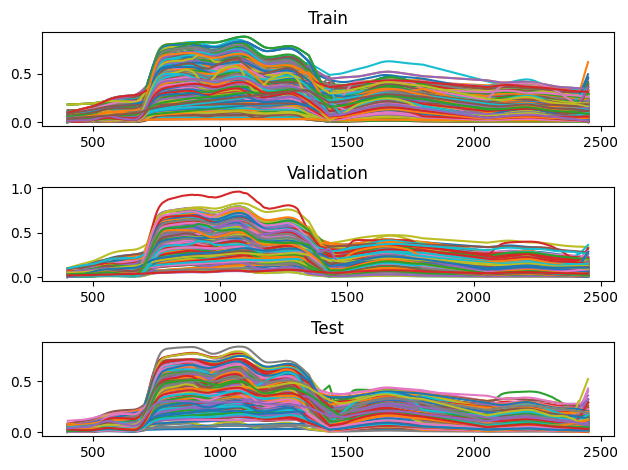

In [59]:
fig, ax = plt.subplots(3, 1)
input_cols_int = list(map(int, input_cols))

for idx, row in X_train.reset_index(drop=True).iterrows():
        ax[0].plot(input_cols_int, row)

for idx, row in X_val.reset_index(drop=True).iterrows():
        ax[1].plot(input_cols_int, row)

for idx, row in X_test.reset_index(drop=True).iterrows():
        ax[2].plot(input_cols_int, row)

ax[0].set_title("Train")
ax[1].set_title("Validation")
ax[2].set_title("Test")
plt.tight_layout()

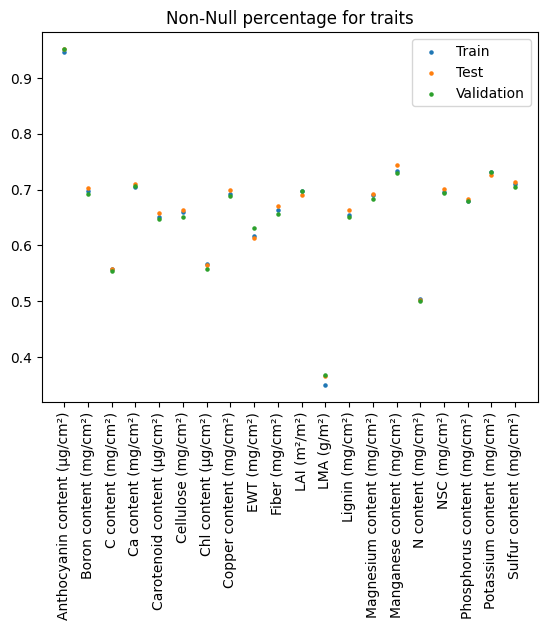

In [60]:
plt.scatter(np.arange(y_train.shape[1]), y_train.isna().sum() / y_train.shape[0], label='Train', s = 5)
plt.scatter(np.arange(y_train.shape[1]), y_test.isna().sum() / y_test.shape[0], label='Test', s = 5)
plt.scatter(np.arange(y_train.shape[1]), y_val.isna().sum() / y_val.shape[0], label='Validation', s = 5)

plt.title("Non-Null percentage for traits")
plt.xticks(np.arange(len(target_cols)), target_cols, rotation = 90)
plt.legend()
plt.show()

# Normalization

In [61]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = input_cols)

X_test = pd.DataFrame( scaler.transform(X_test), columns = input_cols)
X_val =pd.DataFrame( scaler.transform(X_val), columns = input_cols)



# Visualizing Split after Normalization

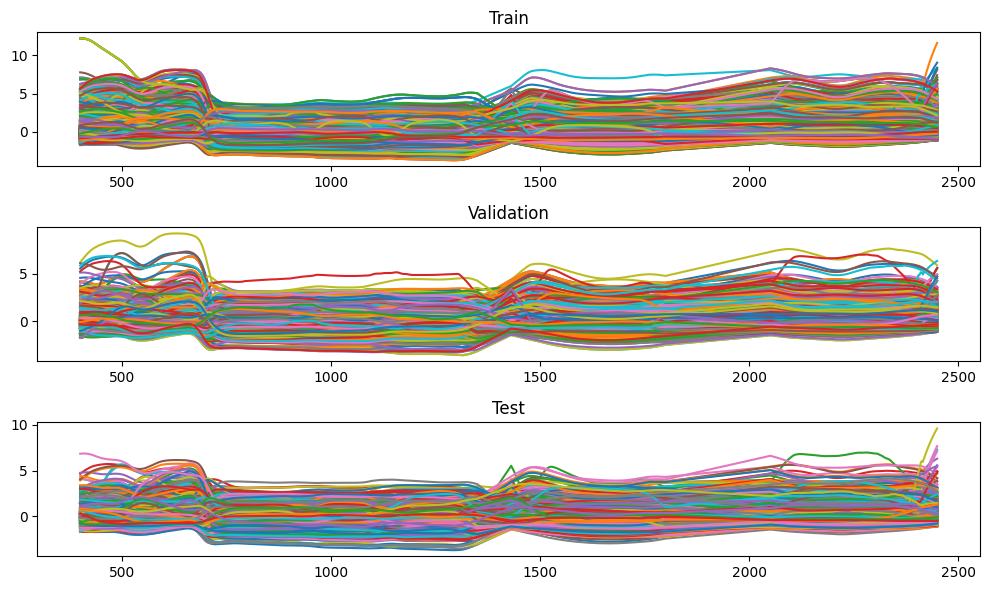

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
input_cols_int = list(map(int, input_cols))

for idx, row in X_train.reset_index(drop=True).iterrows():
        ax[0].plot(input_cols_int, row)

for idx, row in X_val.reset_index(drop=True).iterrows():
        ax[1].plot(input_cols_int, row)

for idx, row in X_test.reset_index(drop=True).iterrows():
        ax[2].plot(input_cols_int, row)

ax[0].set_title("Train")
ax[1].set_title("Validation")
ax[2].set_title("Test")
plt.tight_layout()

# PCA

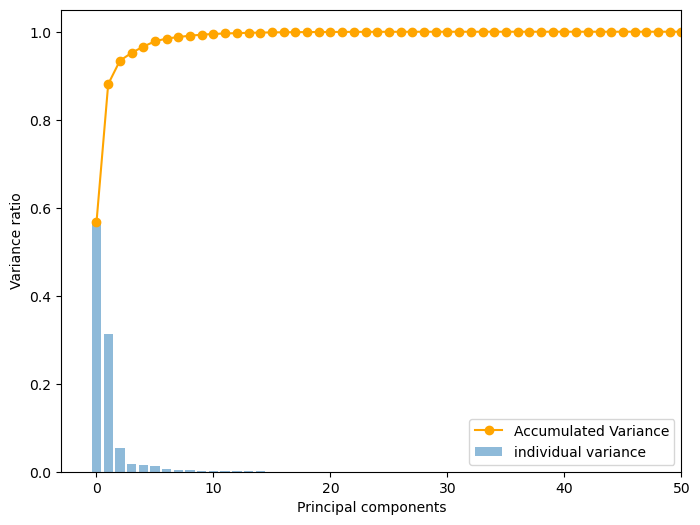

In [15]:
pca = PCA()
pca.fit(X_train)

pca_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(len(input_cols)), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.plot(np.arange(len(input_cols)), np.cumsum(pca_variance), '-o', c='orange', label='Accumulated Variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.xlim(-3, 50)
plt.show()

In [35]:
pca = PCA(n_components=2)
pca.fit(X_train)
pca_data = pd.concat([pd.DataFrame(pca.transform(X_test)), pd.DataFrame(pca.transform(X_val))], axis=0)
pca_data = pd.concat([pca_data, pd.concat([y_test.reset_index(drop=True), y_val.reset_index(drop=True)], axis=0)], axis=1)

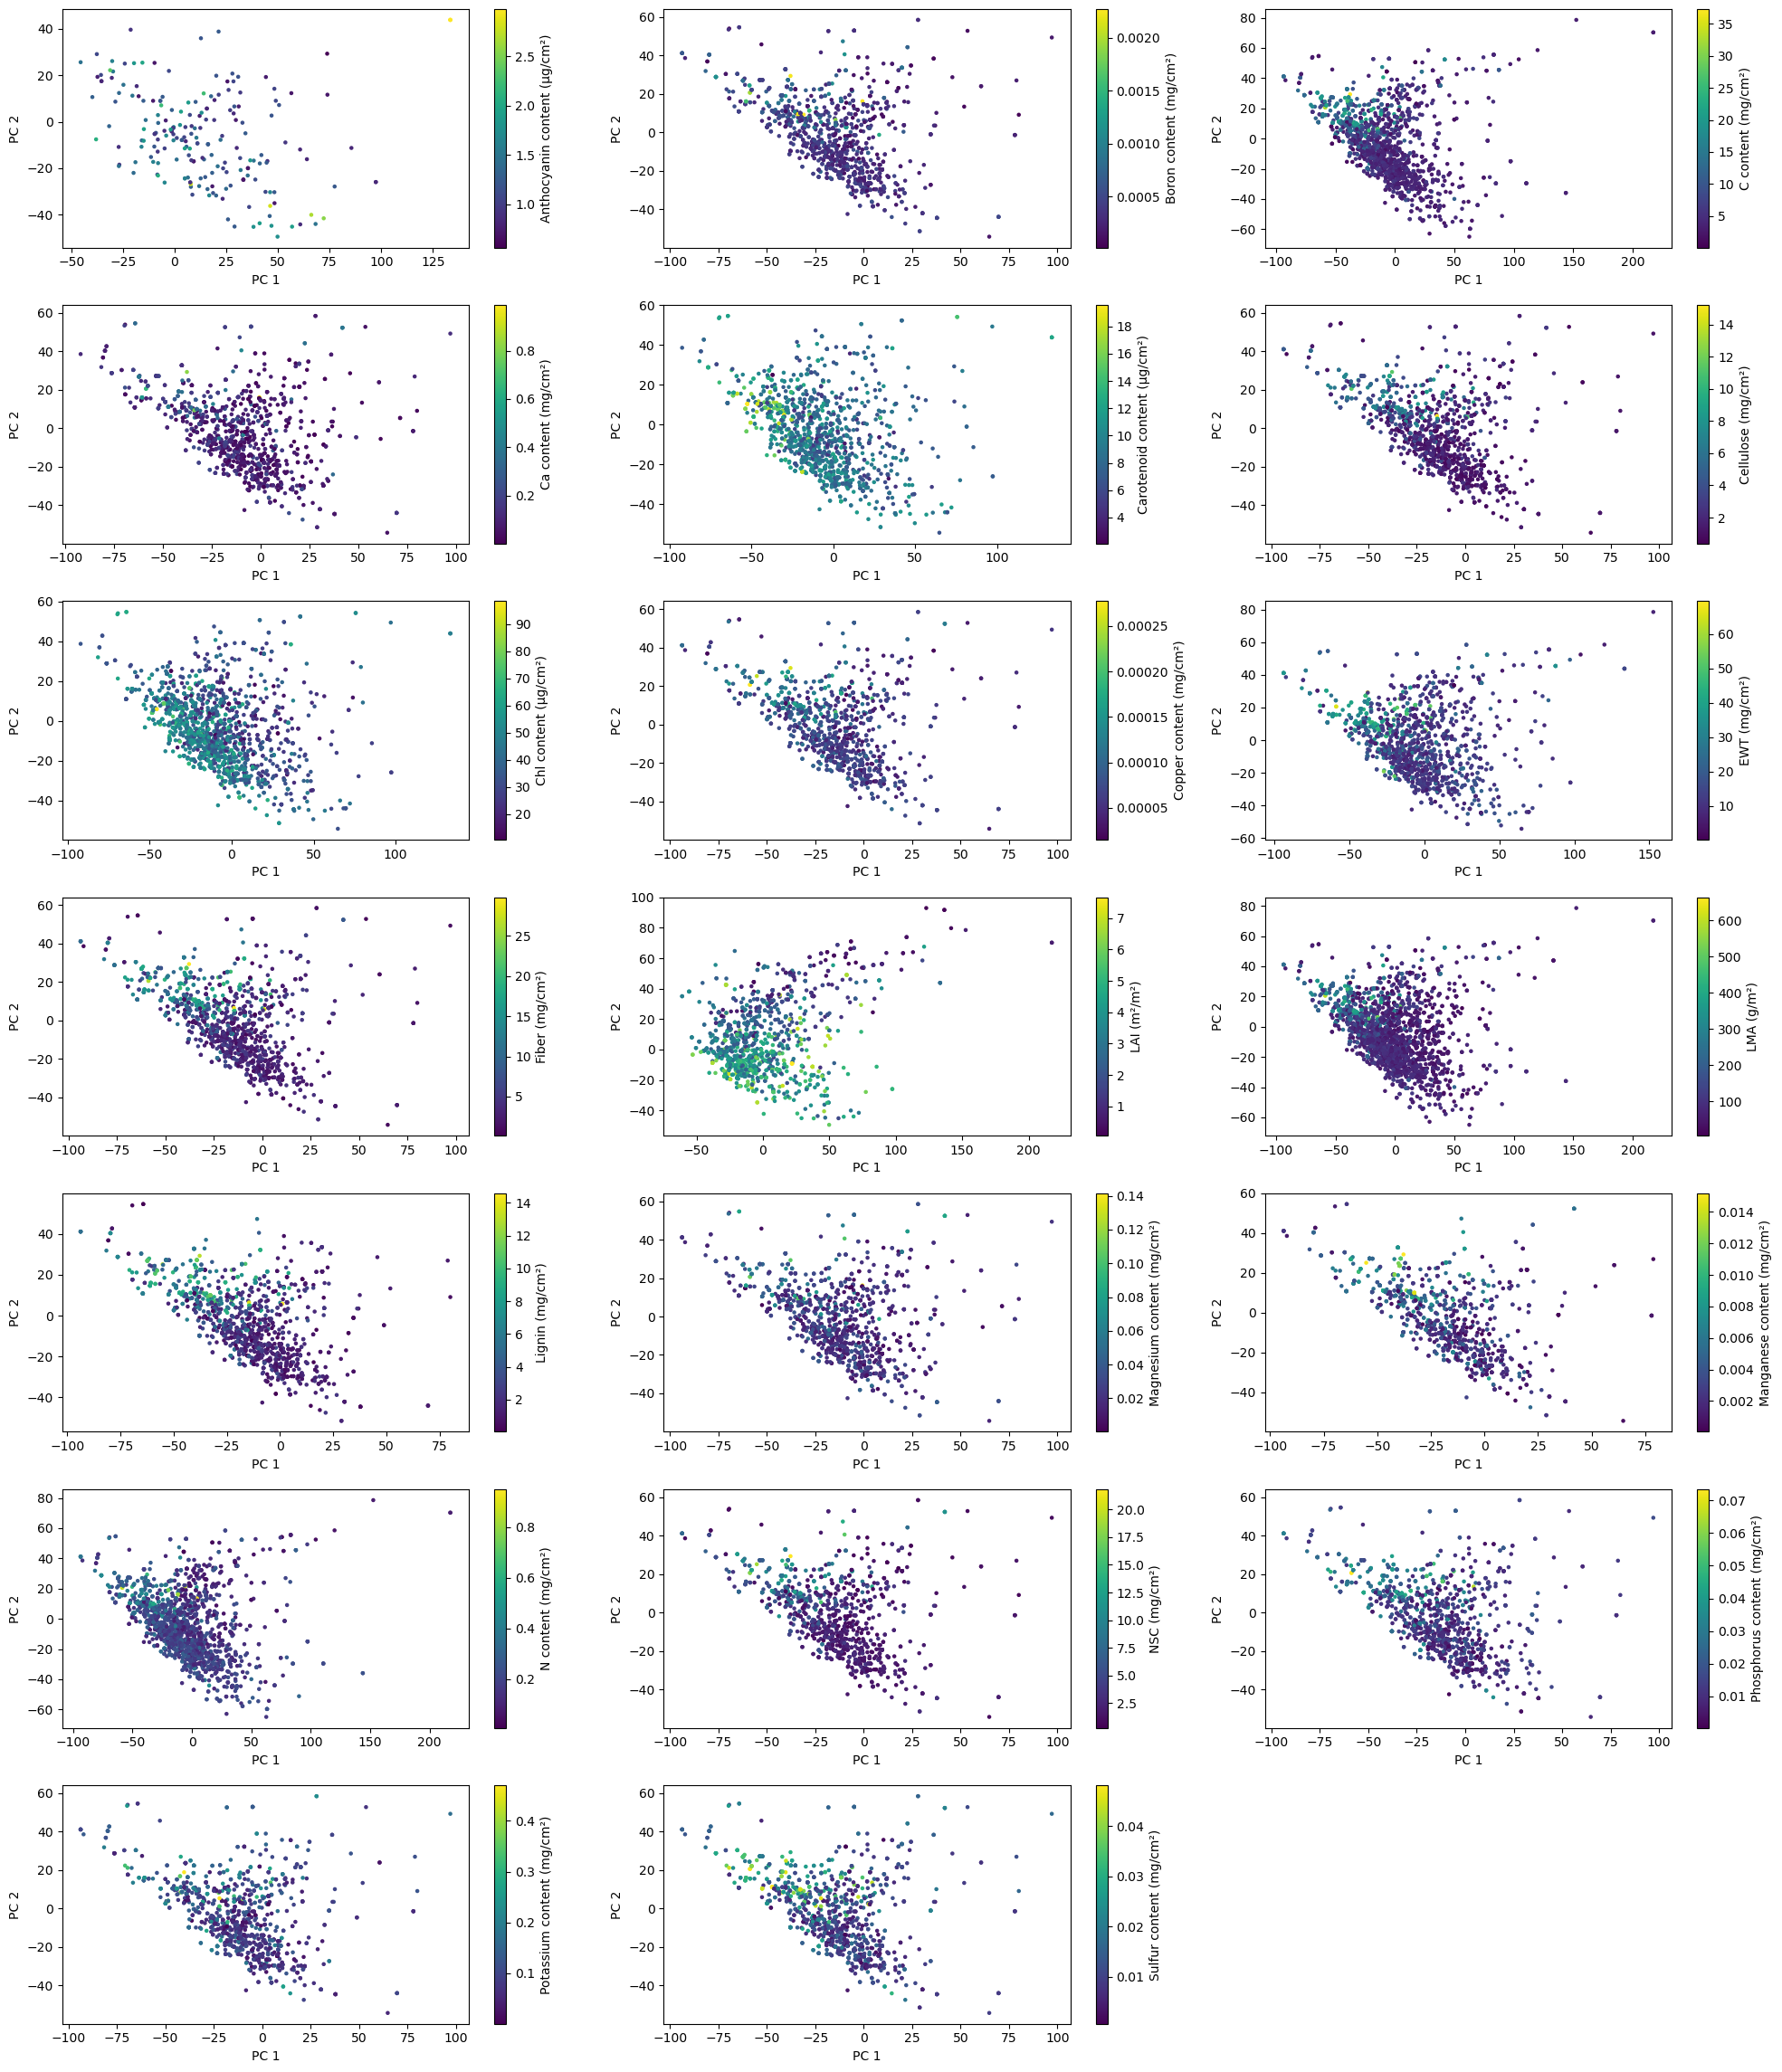

In [36]:
colormap = plt.get_cmap('viridis')
fig, ax = plt.subplots(7,3, figsize = (20, 23))

for idx_target, target in enumerate(target_cols):
    filtered_data = pca_data[~pca_data[target].isna()] # Keeping only non-na samples
    target_values = filtered_data[target].to_numpy() # Selecting the target values

    # To plot the colorbar
    norm = plt.Normalize(min(target_values), max(target_values))
    sm = ScalarMappable(cmap=colormap, norm=norm)

    ax[idx_target // 3][idx_target % 3].scatter(filtered_data[0], filtered_data[1], c = sm.to_rgba(target_values), s = 5)

    # Adding plot information
    plt.colorbar(sm, ax = ax[idx_target // 3][idx_target % 3], label=target)
    ax[idx_target // 3][idx_target % 3].set_xlabel("PC 1")
    ax[idx_target // 3][idx_target % 3].set_ylabel("PC 2")

ax[6, 2].axis('off')
plt.tight_layout()
plt.show()

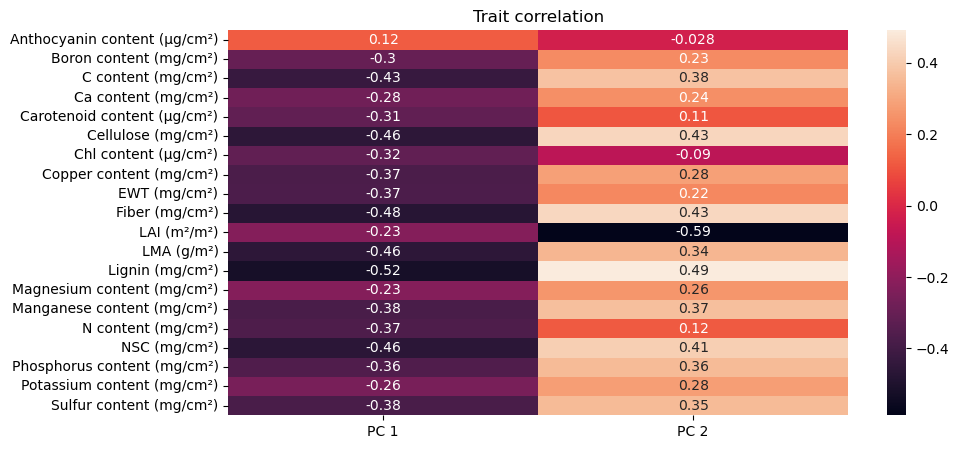

In [37]:
# Plotting correlation
plt.subplots(figsize=(10, 5))
corr = pca_data.corr()

sns.heatmap( corr[[0,1]].iloc[2:].rename({0:'PC 1', 1:'PC 2'}, axis=1), annot=True )
plt.title("Trait correlation")
plt.show()

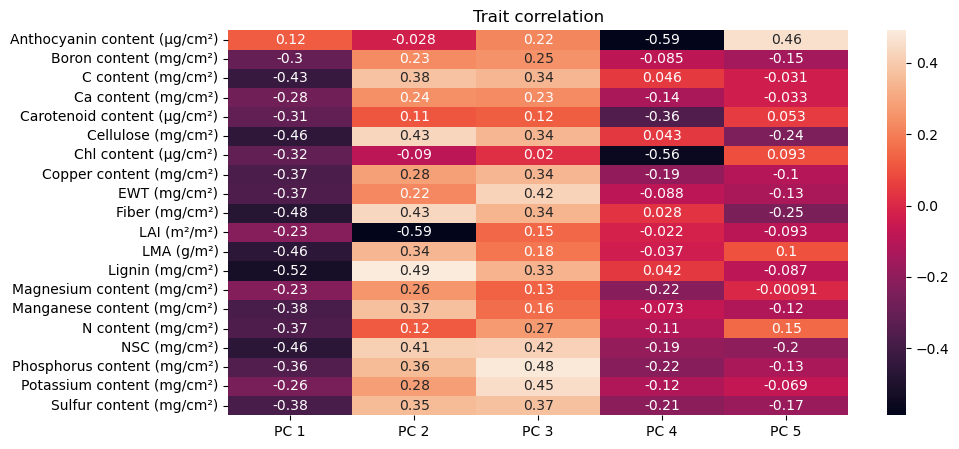

In [39]:
pca = PCA(n_components=5)
pca.fit(X_train)
pca_data = pd.concat([pd.DataFrame(pca.transform(X_test)), pd.DataFrame(pca.transform(X_val))], axis=0)
pca_data = pd.concat([pca_data, pd.concat([y_test.reset_index(drop=True), y_val.reset_index(drop=True)], axis=0)], axis=1)

# Plotting correlation
plt.subplots(figsize=(10, 5))
corr = pca_data.corr()

sns.heatmap( corr[[0,1, 2, 3, 4]].iloc[5:].rename({0:'PC 1', 1:'PC 2', 2:'PC 3', 3:'PC 4', 4:'PC 5'}, axis=1), annot=True )
plt.title("Trait correlation")
plt.show()

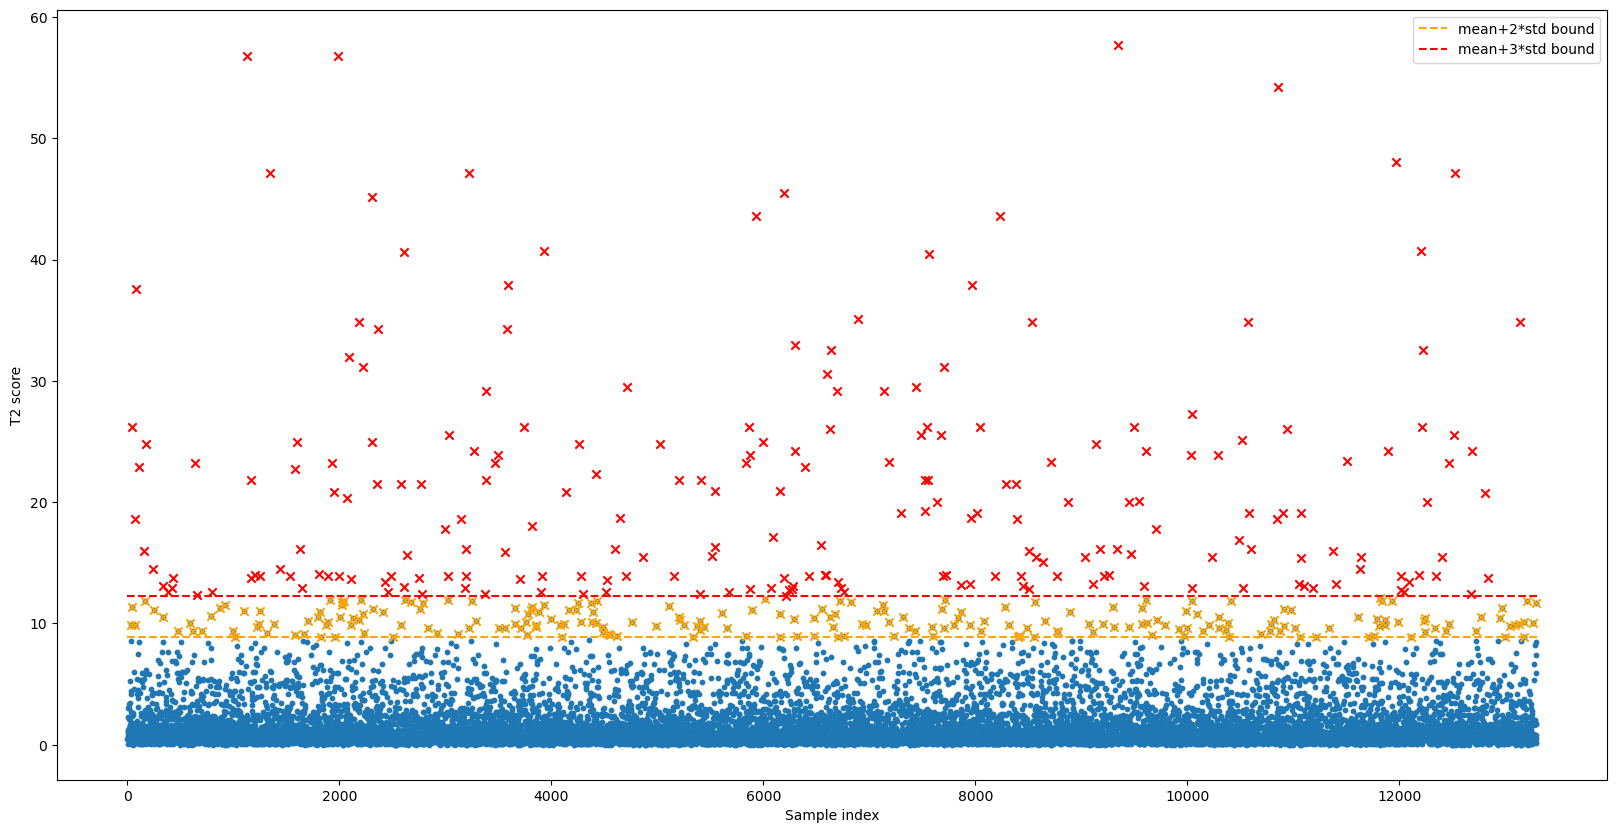

In [43]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_train)
pca_data = pd.concat([pd.DataFrame(pca.transform(X_test)), pd.DataFrame(pca.transform(X_val)), pd.DataFrame(pca_data)], axis=0).to_numpy()

t_1 = pca_data[:, 0]; t_2 = pca_data[:, 1]
s_1 = np.std(t_1); s_2 = np.std(t_2)

T2 = np.power(t_1/s_1, 2) + np.power(t_2/s_2, 2)
upper_2 = np.mean(T2)+2*np.std(T2)
upper_3 = np.mean(T2)+3*np.std(T2)

plt.subplots(figsize=(20, 10))
plt.scatter(np.where(T2 < upper_3), T2[np.where(T2 < upper_3)], s=10)
plt.plot([0, len(T2)], [upper_2, upper_2], '--', c='orange', label='mean+2*std bound')
plt.plot([0, len(T2)], [upper_3, upper_3], '--', c='red', label='mean+3*std bound')
plt.scatter(np.where(T2 > upper_3), T2[np.where(T2 > upper_3)], marker='x', c='red')
plt.scatter(np.where((T2 < upper_3) * (T2 > upper_2)), T2[np.where((T2 < upper_3) * (T2 > upper_2))], marker='x', c='orange')
plt.legend()
plt.ylabel("T2 score")
plt.xlabel("Sample index")
plt.show()

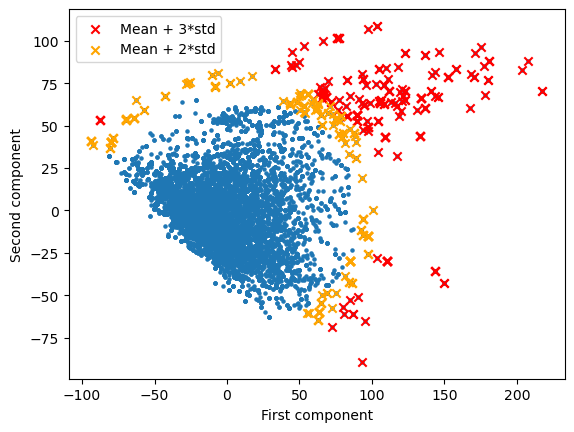

In [44]:
# Plotting first two components
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.scatter(pca_data[np.where(T2>upper_3)][:,0], pca_data[np.where(T2>upper_3)][:,1],marker='x', c='red', label='Mean + 3*std')
plt.scatter(pca_data[np.where((T2 < upper_3) * (T2 > upper_2))][:,0], pca_data[np.where((T2 < upper_3) * (T2 > upper_2))][:,1], marker='x', c='orange', label='Mean + 2*std')
plt.legend()
plt.show()

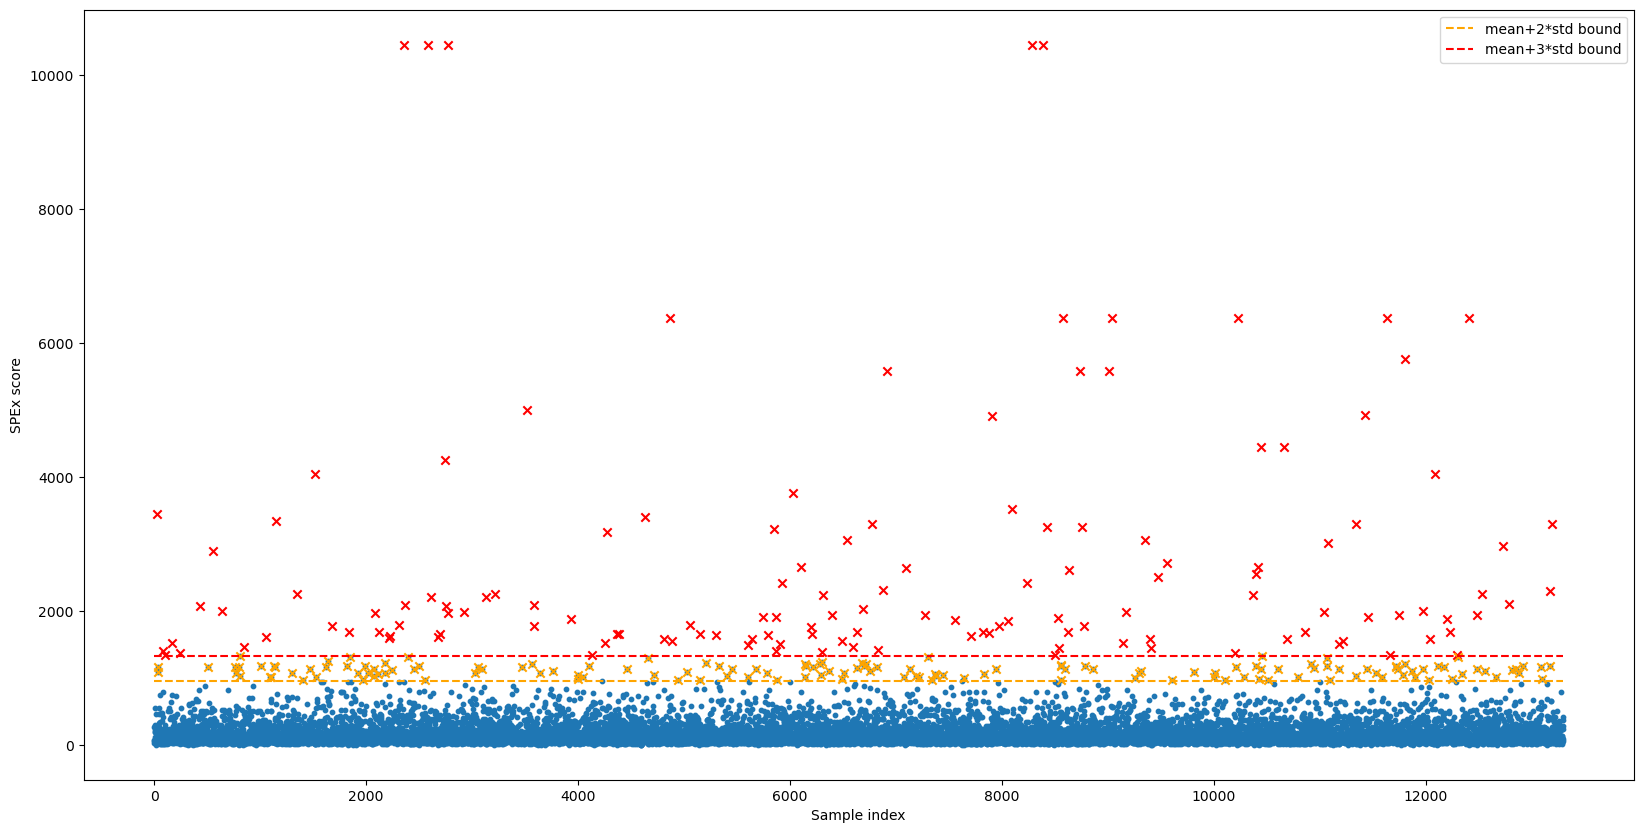

In [46]:
reconstructed_data = pca.inverse_transform(pca_data)
SPE = np.power(pd.concat([X_test, X_val, X_train], axis=0)-reconstructed_data, 2).sum(axis=1).to_numpy()
upper_2_spe = np.mean(SPE)+2*np.std(SPE)
upper_3_spe = np.mean(SPE)+3*np.std(SPE)

plt.subplots(figsize=(20, 10))
plt.scatter(np.where(SPE < upper_3_spe), SPE[np.where(SPE < upper_3_spe)], s=10)
plt.plot([0, len(SPE)], [upper_2_spe, upper_2_spe], '--', c='orange', label='mean+2*std bound')
plt.plot([0, len(SPE)], [upper_3_spe, upper_3_spe], '--', c='red', label='mean+3*std bound')
plt.scatter(np.where(SPE > upper_3_spe), SPE[np.where(SPE > upper_3_spe)], marker='x', c='red')
plt.scatter(np.where((SPE < upper_3_spe) * (SPE > upper_2_spe)), SPE[np.where((SPE < upper_3_spe) * (SPE > upper_2_spe))], marker='x', c='orange')
plt.legend()
plt.ylabel("SPEx score")
plt.xlabel("Sample index")
plt.show()

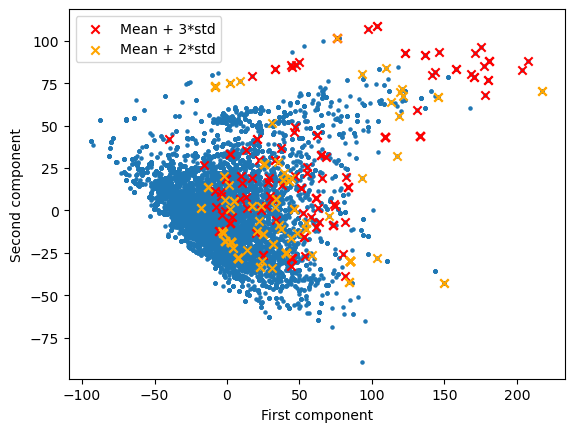

In [47]:
# Plotting first two components
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.scatter(pca_data[np.where(SPE>upper_3_spe)][:,0], pca_data[np.where(SPE>upper_3_spe)][:,1],marker='x', c='red', label='Mean + 3*std')
plt.scatter(pca_data[np.where((SPE < upper_3_spe) * (SPE > upper_2_spe))][:,0], pca_data[np.where((SPE < upper_3_spe) * (SPE > upper_2_spe))][:,1], marker='x', c='orange', label='Mean + 2*std')
plt.legend()
plt.show()

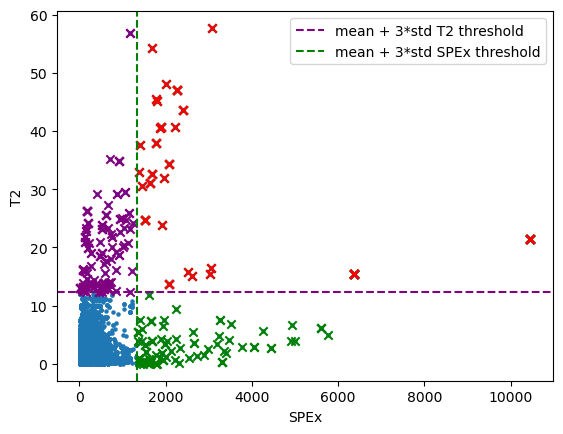

In [48]:
plt.scatter(SPE, T2, s=5)
plt.scatter(SPE[T2>upper_3], T2[T2>upper_3], marker='x', color='purple')
plt.scatter(SPE[SPE>upper_3_spe], T2[SPE>upper_3_spe], marker='x', color='green')
plt.scatter(SPE[(SPE>upper_3_spe) * (T2>upper_3)], T2[(SPE>upper_3_spe) * (T2>upper_3)], marker='x', color='red')
plt.axhline(y = upper_3, linestyle='--', color='purple', label='mean + 3*std T2 threshold')
plt.axvline(x = upper_3_spe, linestyle='--', color='green', label = 'mean + 3*std SPEx threshold')
plt.ylabel("T2")
plt.xlabel("SPEx")
plt.legend()
plt.show()

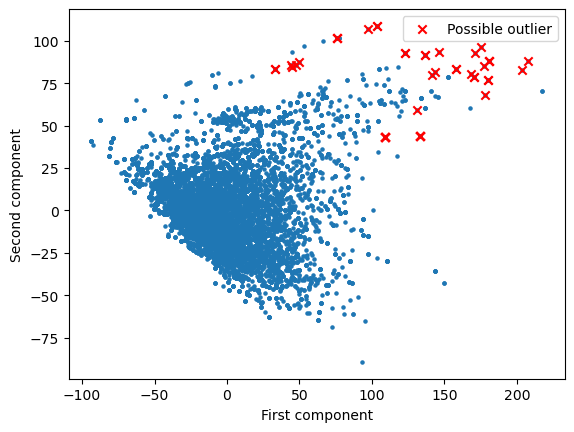

In [49]:
# Plotting first two components
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.scatter(pca_data[(SPE > upper_3_spe) * (T2 > upper_3)][:,0], pca_data[(SPE > upper_3_spe) * (T2 > upper_3)][:,1], marker='x', c='red', label='Possible outlier')
plt.legend()
plt.show()

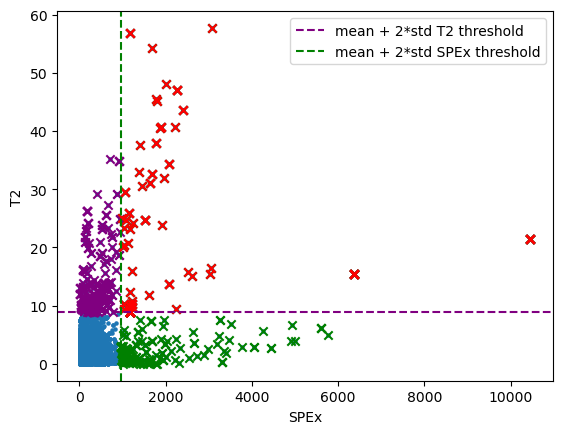

In [50]:
plt.scatter(SPE, T2, s=5)
plt.scatter(SPE[T2>upper_2], T2[T2>upper_2], marker='x', color='purple')
plt.scatter(SPE[SPE>upper_2_spe], T2[SPE>upper_2_spe], marker='x', color='green')
plt.scatter(SPE[(SPE>upper_2_spe) * (T2>upper_2)], T2[(SPE>upper_2_spe) * (T2>upper_2)], marker='x', color='red')
plt.axhline(y = upper_2, linestyle='--', color='purple', label='mean + 2*std T2 threshold')
plt.axvline(x = upper_2_spe, linestyle='--', color='green', label = 'mean + 2*std SPEx threshold')
plt.ylabel("T2")
plt.xlabel("SPEx")
plt.legend()
plt.show()

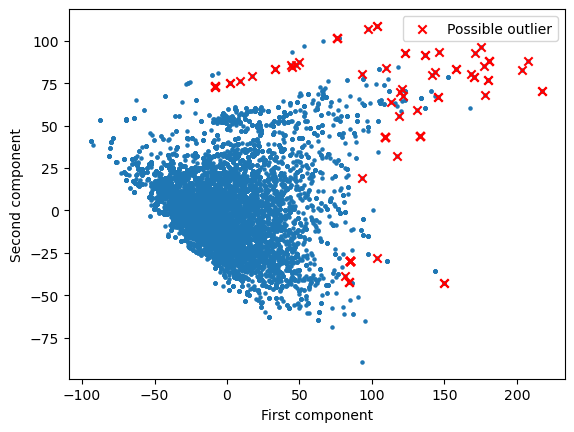

In [51]:
# Plotting first two components
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.scatter(pca_data[(SPE > upper_2_spe) * (T2 > upper_2)][:,0], pca_data[(SPE > upper_2_spe) * (T2 > upper_2)][:,1], marker='x', c='red', label='Possible outlier')
plt.legend()
plt.show()

# Outliers: Z-score Method

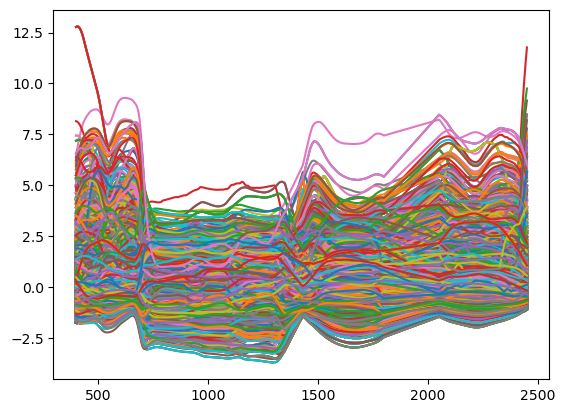

In [34]:
input_cols_int = list(map(int, input_cols))

for idx, row in X_train.reset_index(drop=True).iterrows():
        plt.plot(input_cols_int, row)

for idx, row in X_val.reset_index(drop=True).iterrows():
        plt.plot(input_cols_int, row)

for idx, row in X_test.reset_index(drop=True).iterrows():
        plt.plot(input_cols_int, row)

plt.show()